Comparing Variational Inference (ADVI mean-field and full-rank) and MCMC state-of-the-art No-U-Turn-Sampler (NUTS) for inference on an ODE model of NeuroImaging.

author: Nina Baldy, INS AMU

In [1]:
import os
import sys
import time
import errno
import timeit
import pathlib

import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
cwd = os.getcwd()
main_path = str(pathlib.Path.cwd().parent)
sys.path.append(main_path) # Path to import the model and solver

In [3]:
import cmdstanpy

In [4]:
cmdstanpy_output_dir = cwd + '/output_cmdstanpy/'
! mkdir -p $cmdstanpy_output_dir

In [5]:
cwd = os.getcwd()
main_path = str(pathlib.Path.cwd().parent)
sys.path.append(main_path) # Path to import the model and solver

In [6]:
from Helper.ERPhelper import *
from Helper.report_advi import convergence_advi, advi_elbo

In [7]:
for pckg in [np, cmdstanpy, az] :
    print(f" {pckg.__name__} version: {pckg.__version__}")

 numpy version: 1.26.4
 cmdstanpy version: 1.1.0
 arviz version: 0.17.0


In [8]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action="ignore", category=FutureWarning)

In [9]:
az.style.use("arviz-darkgrid")
colors_l = ["#A4C3D9", "#7B9DBF", "#52779F", "#2A537E"] 

In [10]:
def mse(x, y) :
    return np.mean((x - y)**2)

## Background

### Motivation

Ordinary differential equation models (ODEs) are used in a variety of science and engineering domains to model the time evolution of physical variables.  A natural choice to estimate the values and uncertainty of model parameters given experimental data is Bayesian inference.  However, ODEs can be challenging to specify and solve in the Bayesian setting, therefore, this notebook steps through multiple methods for solving an ODE inference problem using JAX's Odeint. Alternative is to use diffrax, which can be found in forward simuations in the repo. The neural mass model used in this example has often been used in dynamical cuasal modeling and other approaches to fit various neuroimaging data such as ERP/EEG/MEG.

### Neural Mass Model

The mode of Olivier David et al describes the interaction between theree neural populations of pyramidal (x9), 
inhibitory interneuron (x7) 
spiny-stellate cells (x1).

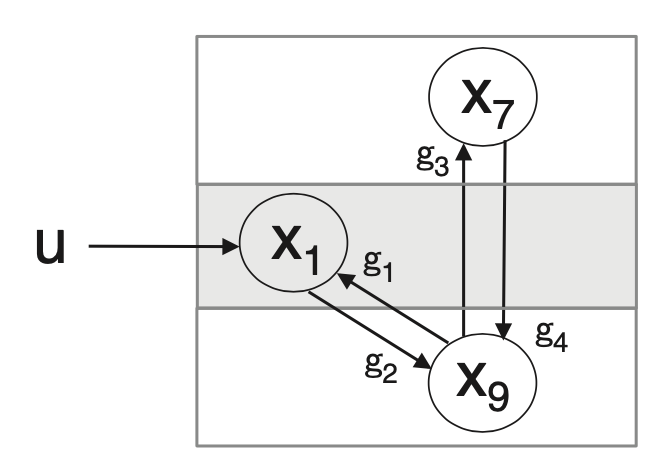

In [11]:
from IPython.display import Image
Image(filename='../Images/model.png', width=400) 

This ODE given by:




\begin{array}{l}
\frac{dx_{1}(t)}{dt} = x_{4}(t) \\
\frac{dx_{2}(t)}{dt} = x_{5}(t) \\
\frac{dx_{3}(t)}{dt} = x_{6}(t) \\
\frac{dx_{7}(t)}{dt}  = x_{8}(t) \\
\frac{dx_{4}(t)}{dt} = \frac{{h_{e}(g_{1}(\frac{1}{e^{-0.56x_{9}(t-\delta)}+1} - 0.5) + u)}}{{\tau_{e}}} - \frac{{x_{1}(t)}}{{\tau_{e}^{2}}} - \frac{{2x_{4}(t)}}{{\tau_{e}}} \\
\frac{dx_{5}(t)}{dt}  = \frac{{g_{2}(\frac{1}{e^{-0.56x_{1}(t-\delta)}+1} - 0.5)}}{{\tau_{e}}} - \frac{{x_{2}(t)}}{{\tau_{e}^{2}}} - \frac{{2x_{5}(t)}}{{\tau_{e}}} \\
\frac{dx_{6}(t)}{dt}  = \frac{{g_{4}(\frac{1}{e^{-0.56x_{7}(t-\delta)}+1} - 0.5)}}{{\tau_{i}}} - \frac{{x_{3}(t)}}{{\tau_{i}^{2}}} - \frac{{2x_{6}^{t}}}{{\tau_{i}}} \\
\frac{dx_{8}(t)}{dt}  = \frac{{g_{3}(\frac{1}{e^{-0.56x_{9}(t-\delta)}+1} - 0.5)}}{{\tau_{e}}} - \frac{{x_{7}(t)}}{{\tau_{e}^{2}}} - \frac{{2x_{8}(t)}}{{\tau_{e}}} \\
\frac{dx_{9}(t)}{dt}  = x_{5}(t) - x_{6}(t)
\end{array}



The state vector $X(t)=[x_1(t), ...x_9(t)]$ comprises the densities of activity of nerural populations.  Parameters $\boldsymbol{\theta}=[g_1, g_2, g_3, g_4, \delta,\tau_i, h_i, \tau_e, h_e, u ]$ are the unknowns that we wish to infer from experimental observations.  

$x(0)$ is the initial values of the states needed to solve the ODE, and are fixed to zero for all variables. 


The unknown model parameters which represent the following:  
* $g_1, g_2, g_3, g_4$ are connection strengths.
* $\delta$ is the intrinsic delay.
* $h_{e,i}$ are maximum amplitude of excitatory (e), and inhibitory (i) post-synaptic potential.
* $\tau_{e, i}$ are the excitatory (e), and inhibitory (i) rate-constant of the membrane,
* $u$  is the input to the neural population.

## Load data

In [12]:
data_dict = dict(np.load("ERP_data.npz"))

In [13]:
data_dict.keys()

dict_keys(['nd', 'nn', 'nt', 'ns', 'nt_model', 't0', 'tend', 'dt', 'ts', 'ds', 'x_init', 'xpy_model', 'xpy_obs', 'xs_obs', 'theta_true', 'alpha', 'eps', 'sig', 'xlim'])

In [14]:
theta_true = data_dict['theta_true']
n_params = len(theta_true)
my_var_names = ['g_1', 'g_2', 'g_3', 'g_4', 'delta', 'tau_i', 'h_i', 'tau_e', 'h_e', 'u']
obs_noise = data_dict['eps']

In [15]:
n_states = data_dict['ns'] ; ts_obs = data_dict['ts'] ; ds = data_dict['ds'] ;
nt = data_dict['nt'] ;
dt = data_dict['dt']/data_dict['ds'] ; n_steps_model = data_dict['nt_model']
ts_model = np.linspace(data_dict['t0'], data_dict['tend'], n_steps_model)
xpy_obs = data_dict['xpy_obs'] ; xpy_model = data_dict['xpy_model'][::ds]

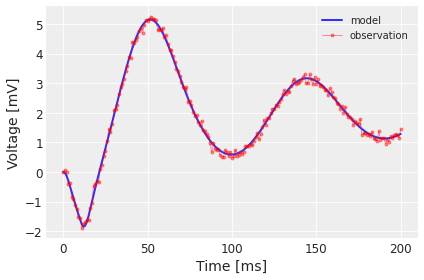

In [16]:
plot_observation(ts_obs, xpy_model, ts_obs, xpy_obs);

## Prior

In [17]:
shape=[18.16, 29.9, 29.14, 30.77, 22.87, 34.67, 20.44, 33.02, 24.17, 23.62]
scale=[0.03, 0.02, 0.005, 0.007, 0.51, 0.23, 0.96, 0.16, 0.07, 0.13]
rate = 1. / np.array(scale)
prior_specs = dict(shape=shape, rate=rate, scale=scale)

In [18]:
n_ = 1000
prior_samples = np.random.gamma(prior_specs['shape'], prior_specs['scale'], size=(n_, n_params))
prior_samples_dict = dict(zip(my_var_names, prior_samples.T))

## Preparing data

In [19]:
stan_data = data_dict.copy()
stan_data['n_params'] = n_params
stan_data['obs_err'] = data_dict['eps']
stan_data['prior_gamma_shape'] = prior_specs['shape']
stan_data['prior_gamma_rate'] = prior_specs['rate']

## Hyperparameters

In [20]:
# sampler initialization: a fair common starting point
np.random.seed(0)
_, low_prob_sample_vals, q_ = low_prob_sample(my_var_names, prior_samples_dict)
init_values = dict(zip(my_var_names, low_prob_sample_vals))

In [21]:
# global parameters for NUTS
#these are the default values in most softwares

global_maxtreedepth = 10
global_accept = 0.8

In [22]:
#iterations

tune, draws, n_chains = 200, 200, 4
n_advi = n_chains
n_iter = 100000

## Benchmark quantities

In [23]:
def compute_marks(az_trace) :
    ess_bulk = az.ess(az_trace, var_names=my_var_names, method='bulk').to_array().values
    ess_tail = az.ess(az_trace, var_names=my_var_names, method='tail').to_array().values
    r_hat = az.rhat(az_trace, var_names=my_var_names).to_array().values
    mse_fit = mse(xpy_obs, az_trace.posterior['xpy_model'].mean(axis=(0, 1)).to_numpy().flatten())
    corr = az.extract(az_trace, var_names=my_var_names).to_pandas().corr().to_numpy()
    corr[np.tril_indices(corr.shape[0])] = np.nan
    meancorr = np.nanmean(np.abs(corr))
    
    return {'ESS bulk': ess_bulk, 
            'ESS tail': ess_tail, 
            'mean ESS bulk': np.mean(ess_bulk),
            'mean ESS tail': np.mean(ess_tail),
            'r hat': r_hat,
            'mean r hat': np.mean(r_hat),
            'MSE fit': mse_fit,
            'corr mat': corr,
            'mean corr': meancorr}
    
def append_marks(df, setup, time, marks_dict) :
    return df._append({'setup': setup,
                       'time': time,
                       **{k:v for k, v in marks_dict.items()}
                      }, ignore_index=True)

In [24]:
bench_df = pd.DataFrame({})

## Stan model

In [25]:
model_name = 'DCM_ERP_sampling_GammaPrior'
stanfile = os.path.join(cwd, model_name + '.stan')
model = cmdstanpy.CmdStanModel(stan_file=stanfile)
model.compile()

In [26]:
with open(stanfile) as f :
    print(f.read())

functions {
  real Sigmodal(real x1,  real x2, real delta, real alpha ) {
       real S=(1.0/(1.0+exp(alpha*(x1-(delta*x2)))))-0.5;
    return S;
  }
}


data {
  int ns;                                       
  int nt;
  real dt; 
  int ds;
  real alpha;    
  row_vector[nt] xpy_obs;  
  int n_params; 
  row_vector[n_params] prior_gamma_shape; 
  row_vector[n_params] prior_gamma_rate; 
  real obs_err;
}


transformed data {
   vector[ns] x_init;
   x_init=rep_vector(0.,ns);
  real dt_full = dt/ds;
  int nt_full = (nt-1)*ds + 1;

}

parameters{
    real<lower=0.0>  g_1;
    real<lower=0.0>  g_2;
    real<lower=0.0>  g_3;
    real<lower=0.0>  g_4;
    real<lower=0.0>  delta;
    real<lower=0.0>  tau_i;
    real<lower=0.0>  h_i;
    real<lower=0.0>  tau_e;
    real<lower=0.0>  h_e;
    real<lower=0.0>  u;
}

transformed parameters {
}

model {

    matrix[ns, nt_full] x;
    vector[ns] dx;
    array[nt] int nt_indexing = linspaced_int_array(nt, 1, nt_full);
    row_vector[nt] x_hat;    


## Automatic Differentiation Variational Inference (ADVI): mean field

In [27]:
alg = 'meanfield'
advi_output_dir =  cmdstanpy_output_dir + 'output_advi/' + alg + '/'
print(advi_output_dir)

/mnt/data/tng/phd/DCM/DCM_ERP_new/github/Benchmark/output_cmdstanpy/output_advi/meanfield/


In [ ]:
start_time = time.time()

i = 0
while i < n_advi :
    try :
        model.variational(data=stan_data, inits=init_values, output_dir=advi_output_dir, 
                          iter=n_iter,
                          tol_rel_obj=0.00001,
                          elbo_samples=1,
                          grad_samples=1,                          
                          require_converged=False,
                          output_samples=draws)
        i += 1
    except :
        continue
        
time_meanfield = time.time() - start_time
print("---running advi mean-field took: %s seconds ---" % time_meanfield)

18:40:00 - cmdstanpy - INFO - Chain [1] start processing
18:40:00 - cmdstanpy - INFO - Chain [1] done processing
18:40:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
18:40:01 - cmdstanpy - INFO - Chain [1] start processing


In [29]:
converged = np.zeros(n_advi)
files_converged = []
ELBO_advi = []
i=0
for files in os.listdir(advi_output_dir) :
    if files.endswith('.txt'):
        if convergence_advi(advi_output_dir + files) == 1:
            converged[i] = 1
            i+=1
            files_converged.append(files[:-13])
            Iter, ELBO = advi_elbo(advi_output_dir + files)
            ELBO_advi.append(ELBO)

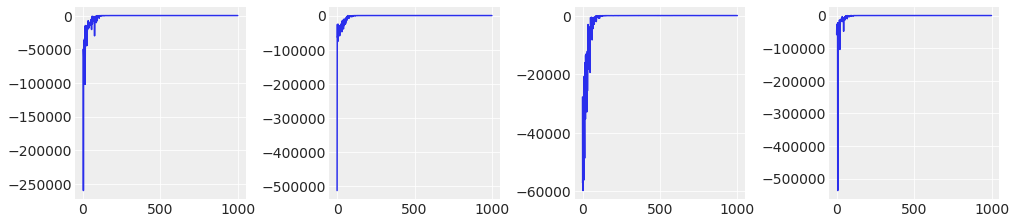

In [30]:
fig, ax = plt.subplots(ncols=n_advi, figsize=(14, 3))
for i in range(n_advi) :
    ax[i].plot(ELBO_advi[i])

In [31]:
trace_meanfield = az.from_cmdstan([advi_output_dir + file + '.csv' for file in files_converged])

In [32]:
az.summary(trace_meanfield, var_names=my_var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
g_1,0.522,0.106,0.324,0.711,0.004,0.003,759.0,806.0,1.00
g_2,0.767,0.004,0.759,0.773,0.002,0.001,7.0,39.0,1.55
g_3,0.147,0.001,0.146,0.148,0.000,0.000,10.0,83.0,1.35
g_4,0.217,0.001,0.216,0.219,0.000,0.000,13.0,259.0,1.23
delta,12.238,0.028,12.190,12.293,0.001,0.001,848.0,656.0,1.02
tau_i,7.709,0.026,7.663,7.759,0.001,0.001,694.0,740.0,1.01
h_i,21.196,0.096,21.020,21.360,0.033,0.024,9.0,69.0,1.42
tau_e,5.756,0.010,5.735,5.775,0.000,0.000,805.0,742.0,1.00
h_e,1.611,0.009,1.598,1.628,0.004,0.003,7.0,34.0,1.63
u,3.399,0.476,2.554,4.278,0.016,0.011,943.0,651.0,1.00


In [33]:
marks_meanfield = compute_marks(trace_meanfield)

In [34]:
bench_df = append_marks(bench_df, 
                        setup='ADVI mean field', 
                        time=time_meanfield,
                        marks_dict=marks_meanfield)

## Automatic Differentiation Variational Inference (ADVI): full rank

In [35]:
alg = 'fullrank'
advi_output_dir =  cmdstanpy_output_dir + 'output_advi/' + alg + '/'
print(advi_output_dir)

/mnt/data/tng/phd/DCM/DCM_ERP_new/github/Benchmark/output_cmdstanpy/output_advi/fullrank/


In [36]:
start_time = time.time()

i = 0
while i < n_advi :
    try :
        model.variational(data=stan_data, inits=init_values, algorithm=alg, 
                          output_dir=advi_output_dir, 
                          iter=n_iter,
                          tol_rel_obj=0.00001,
                          elbo_samples=1,
                          grad_samples=1,
                          require_converged=False,
                          output_samples=draws)
        i += 1
        
    except :
        continue
        
time_fullrank = time.time() - start_time
print("---running advi full-rank took: %s seconds ---" % time_fullrank)

17:59:03 - cmdstanpy - INFO - created output directory: /mnt/data/tng/phd/DCM/DCM_ERP_new/github/Benchmark/NEW_output_cmdstanpy/output_advi/fullrank
17:59:03 - cmdstanpy - INFO - Chain [1] start processing
17:59:05 - cmdstanpy - INFO - Chain [1] done processing
17:59:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
17:59:05 - cmdstanpy - INFO - Chain [1] start processing
18:03:20 - cmdstanpy - INFO - Chain [1] done processing
18:03:20 - cmdstanpy - WARNING - The algorithm may not have converged.
Proceeding because require_converged is set to False
18:03:22 - cmdstanpy - INFO - Chain [1] start processing
18:03:23 - cmdstanpy - INFO - Chain [1] done processing
18:03:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
18:03:23 - cmdstanpy - INFO - Chain [1] start processing
18:03:26 - cmdstanpy - INFO - Chain [1] done processing
18:03:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation n

---running advi full-rank took: 1080.7766733169556 seconds ---


In [37]:
converged = np.zeros(n_advi)
files_converged = []
ELBO_advi = []
i=0
for files in os.listdir(advi_output_dir) :
    if files.endswith('.txt'):
        if convergence_advi(advi_output_dir + files) == 1:
            converged[i] = 1
            i+=1
            files_converged.append(files[:-13])
            Iter, ELBO = advi_elbo(advi_output_dir + files)
            ELBO_advi.append(ELBO)

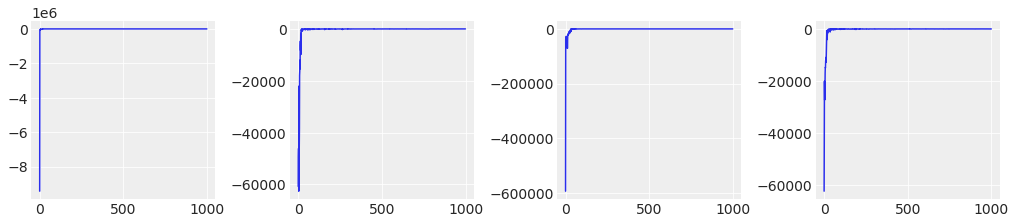

In [38]:
fig, ax = plt.subplots(ncols=n_advi, figsize=(14, 3))
for i in range(n_advi) :
    ax[i].plot(ELBO_advi[i])

In [39]:
trace_fullrank = az.from_cmdstan([advi_output_dir + file + '.csv' for file in files_converged])

In [40]:
az.summary(trace_fullrank, var_names=my_var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
g_1,0.541,0.132,0.302,0.765,0.005,0.003,885.0,862.0,1.00
g_2,0.726,0.109,0.547,0.928,0.005,0.003,553.0,793.0,1.02
g_3,0.141,0.028,0.091,0.195,0.001,0.001,769.0,807.0,1.01
g_4,0.218,0.046,0.138,0.309,0.002,0.001,773.0,734.0,1.00
delta,12.179,0.416,11.390,12.945,0.015,0.010,818.0,821.0,1.00
tau_i,7.709,0.100,7.539,7.909,0.004,0.003,761.0,721.0,1.01
h_i,22.158,5.267,12.689,31.297,0.180,0.127,850.0,734.0,1.01
tau_e,5.790,0.176,5.460,6.108,0.006,0.004,796.0,847.0,1.00
h_e,1.736,0.260,1.286,2.167,0.011,0.008,491.0,809.0,1.02
u,3.341,0.593,2.403,4.561,0.023,0.016,689.0,671.0,1.01


In [41]:
marks_fullrank = compute_marks(trace_fullrank)

In [42]:
bench_df = append_marks(bench_df, 
                        setup='ADVI full rank', 
                        time=time_fullrank,
                        marks_dict=marks_fullrank)

## HMC NUTS

In [43]:
start = time.time()

nuts_fit = model.sample(data=stan_data, 
                       iter_warmup=tune, 
                       iter_sampling=draws, 
                       chains=n_chains,
                       output_dir=cmdstanpy_output_dir,
                       adapt_delta=global_accept, 
                       max_treedepth=int(global_maxtreedepth), 
                       inits=init_values,
                       show_progress=False)

time_nuts = time.time() - start_time
print("---running NUTS took: %s seconds ---" % time_nuts)

18:13:24 - cmdstanpy - INFO - CmdStan start processing
18:13:24 - cmdstanpy - INFO - Chain [1] start processing
18:13:24 - cmdstanpy - INFO - Chain [2] start processing
18:13:24 - cmdstanpy - INFO - Chain [3] start processing
18:13:24 - cmdstanpy - INFO - Chain [4] start processing
18:25:26 - cmdstanpy - INFO - Chain [4] done processing
18:26:19 - cmdstanpy - INFO - Chain [3] done processing
18:26:57 - cmdstanpy - INFO - Chain [1] done processing
18:27:02 - cmdstanpy - INFO - Chain [2] done processing
18:27:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/mnt/data/tng/phd/DCM/DCM_ERP_new/github/Benchmark/DCM_ERP_sampling_GammaPrior.stan', line 55, column 4 to column 59)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/mnt/data/tng/phd/DCM/DCM_ERP_new/github/Benchmark/DCM_ERP_sampling_GammaPrior.stan', line 55, column 4 to column 59)
	Exception: gamma_lpdf: Random v

---running NUTS took: 3115.2380299568176 seconds ---


In [44]:
trace_nuts = az.from_cmdstanpy(nuts_fit)

In [45]:
trace_nuts = az.from_cmdstan(cmdstanpy_output_dir + '/*.csv')

In [46]:
az.summary(trace_nuts, var_names=my_var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
g_1,0.542,0.122,0.319,0.766,0.004,0.003,926.0,500.0,1.00
g_2,0.657,0.076,0.514,0.795,0.004,0.003,396.0,551.0,1.01
g_3,0.141,0.023,0.099,0.183,0.001,0.001,802.0,516.0,1.01
g_4,0.217,0.034,0.153,0.280,0.001,0.001,769.0,534.0,1.01
delta,12.228,0.391,11.494,12.991,0.017,0.012,524.0,430.0,1.01
tau_i,7.702,0.091,7.524,7.867,0.004,0.003,653.0,600.0,1.00
h_i,19.724,3.433,13.974,26.754,0.134,0.099,685.0,427.0,1.00
tau_e,5.771,0.169,5.430,6.060,0.007,0.005,561.0,457.0,1.01
h_e,1.903,0.219,1.492,2.307,0.011,0.008,375.0,588.0,1.01
u,3.246,0.539,2.278,4.245,0.020,0.014,787.0,443.0,1.02


In [47]:
marks_nuts = compute_marks(trace_nuts)

In [48]:
bench_df = append_marks(bench_df, 
                        setup='NUTS', 
                        time=time_nuts,
                        marks_dict=marks_nuts)

## Results

In [50]:
bench_df[['setup', 'time', 'mean r hat', 'MSE fit', 'mean corr']]

,setup,time,mean r hat,MSE fit,mean corr
0,ADVI mean field,1164.259498,1.221246,0.010840,0.124701
1,ADVI full rank,1080.776673,1.006386,0.010840,0.187777
2,NUTS,3115.238030,1.007399,0.010828,0.179450


In [51]:
bench_df.to_csv('bench_nuts_advi.csv')

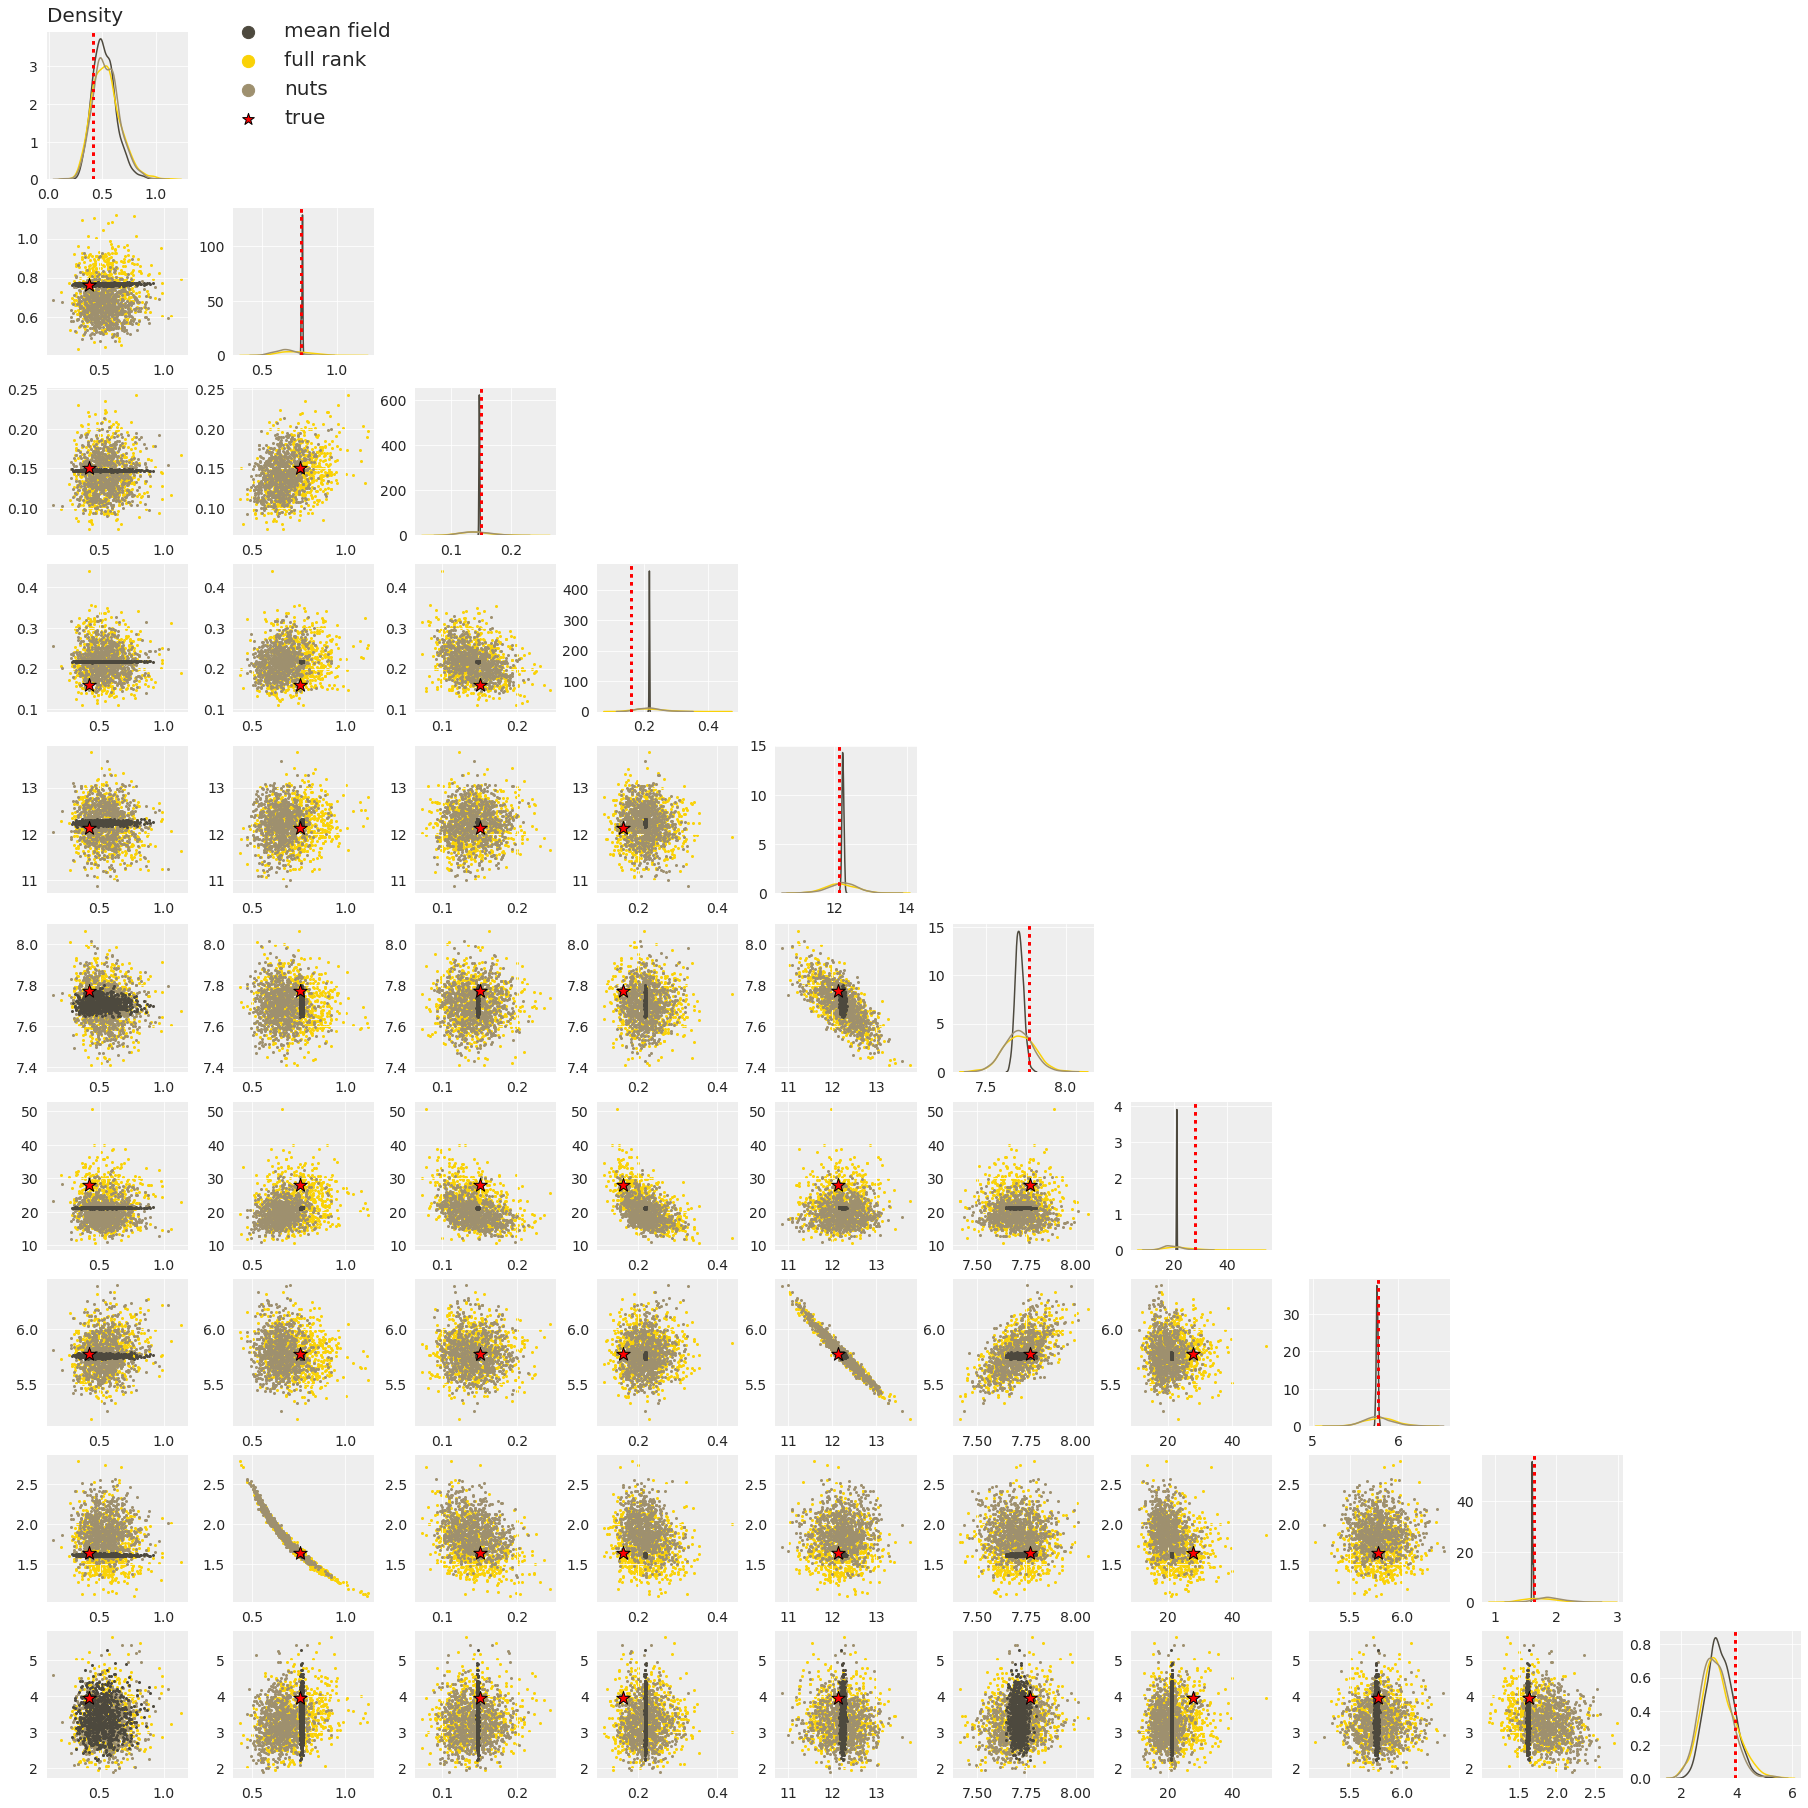

In [52]:
traces_dict = dict(zip(['mean field', 'full rank', 'nuts'], 
                       [trace_meanfield, trace_fullrank, trace_nuts]))
my_var_names = ['g_1', 'g_2', 'g_3', 'g_4', 'delta', 'tau_i', 'h_i', 'tau_e', 'h_e', 'u']
theta_true = np.array([0.42, 0.76, 0.15, 0.16, 12.13, 7.77, 27.87, 5.77, 1.63, 3.94])
params_true_dict = dict(zip(my_var_names, theta_true))

fig, ax = plot_pairs_surperimposed(traces_dict,
                                   my_var_names,
                                   main_palette=['#4d493e', '#fad207', '#9e906f', '#b1face'],
                                   true_values_dict=params_true_dict,
                                   z_orders=[2, 0, 1])

## Setup info

In [53]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Jul 01 2024

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

pandas    : 1.4.3
matplotlib: 3.5.2
numpy     : 1.26.4
arviz     : 0.17.0
cmdstanpy : 1.1.0
sys       : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
seaborn   : 0.13.2

Watermark: 2.4.3



In [54]:
!  lscpu | head -n 16

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Address sizes:                   39 bits physical, 48 bits virtual
Byte Order:                      Little Endian
CPU(s):                          8
On-line CPU(s) list:             0-7
Vendor ID:                       GenuineIntel
Model name:                      Intel(R) Core(TM) i7-7700 CPU @ 3.60GHz
CPU family:                      6
Model:                           158
Thread(s) per core:              2
Core(s) per socket:              4
Socket(s):                       1
Stepping:                        9
CPU max MHz:                     4200.0000
CPU min MHz:                     800.0000
